In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Gala
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

# Astropy
import astropy
from astropy import units as u, constants as const

# Orbital Integration Tutorial

Perhaps the simpliset method of orbital integration involves the classic "Leapfrog" algorithm. The leapfrog algorithm leverages basic numerical integration schemes to solve the equations of motion. Step by step, we hope to show how based on the equations of motion and with an understanding of the underlying potential, we can fully integrate orbital trajectories to high accuracy.

In [26]:
# Calculate the potential given position coordinates
def kep_potential(M, x, y, G):
    """
    Parameters
    ----------
    mass : float
        mass of central body
    x : array
        x-postions
    y : array
        y-postions
    G : float
        Gravitational Constant  
        
    Returns
    ----------
    ax : array
    Potential value 
    """
    r = np.sqrt(x**2 + y**2)
    return (-G*M)/r

# Calculate acceleration given position coordinates
def keplerian_accel(M, x, y, G):
    """
    Parameters
    ----------
    mass : float
        mass of central body
    x : array
        x-postions
    y : array
        y-postions
    G : float
        Gravitational Constant  
        
    Returns
    ----------
    ax : array
        x-accelerations 
    ay : array
        y-accelerations 
    """
    
    # Little trick here -- the following line give you the Cartesian accelerations for 
    # any spherical potential
    # Just replace dr with the derivative of the potential with respect to r (dPhi/dr)
    r = np.sqrt(x**2 + y**2)
    dr = (G*M)/r**2 # Derivative of potential
    ax = -dr * (x/r)
    ay = -dr * (y/r)
    
    return ax, ay

# Calculate circular velocity in Keplerian Potential given position coordinates
def circular_velocity(M, x, y, G):
    """
    Parameters
    ----------
    mass : float
        mass of central body
    x : array
        x-postions
    y : array
        y-postions
    G : float
        Gravitational Constant  
        
    Returns
    ----------
    vc : array
        circular velocity
    """
    r = np.sqrt(x**2 + y**2)
    return np.sqrt((G*M) / r)

# Calculate period of circular orbit in Keplerian potential given position coordinates
def time_period(M, x, y, G):
    """
    Parameters
    ----------
    mass : float
        mass of central body
    x : array
        x-postions
    y : array
        y-postions
    G : float
        Gravitational Constant  
        
    Returns
    ----------
    vc : array
        time period of a circular orbit
    """
    r = np.sqrt(x**2 + y**2)
    vcirc = np.sqrt((G*M) / r)
    return (2*np.pi*r) / vcirc

## Initial Conditions

First, we must define the initial conditions of our orbit. We will focus on orbits in the x-y plane, therefore we need to provide the inital position ($x_0$,$y_0$) and velocity ($v_{0,x}$,$v_{0,y}$) of our tracer particle. These are our initialphase-space coordinates. 

For this exercise, we use the simpliest potential there is, which is the Keplerian Potential, describing the gravitational potential between two bodies. $$\Phi = \frac{-G M}{r}$$ G is the Gravitational Constant, M is the mass of the central body, and r is the distance between the central body and of our tracer particle. Our choice of the central mass and the radial distance defines the strength of the force, and in turn, the acceleration the tracer particle feels along its orbit.

In [27]:
# Initial Conditions for positions and velocity
x_0 = 1 #* u.AU
y_0 = 0 #* u.AU

Mass = 1 #* u.Msun

vx_0 = 0 #* u.m / u.s
vy_0 = 1 #* u.m / u.s

ax_0, ay_0 = keplerian_accel(Mass, x_0, y_0,  G=1) #Initial acceleration from the underlying potential 

For our integration, we must set the size of our steps in time, dt, and how many steps we plan to take along the orbit, N. Both N and dt are free parameters of the integration. Once we choose a value of N and dt, we can step of empty arrays of position, velocity, and acceleration which will be filled over the course of the leapfrog integration. 

With our knowledge of the positions and velocities, it is good to also track the total energy, E, of the gravitating system. We can calculate this easily from the sum of the kinetic and potential energy. Recording the energy will tell us how bound or unbound our orbit is in our defined potential.

In [28]:
N = 100 # number of steps in orbit integration
dt = 0.1 #* u.yr # size of the steps in time

dt_ = dt #.value # .value strips away units
t = np.arange(0,N*dt_,dt_) # time interval over which we are integrating the orbit

# Arrays of positions, velocities, and acccelerations
x = np.zeros(len(t)) #* u.AU
y = np.zeros(len(t)) #* u.AU

vx = np.zeros(len(t)) #* u.m / u.s
vy = np.zeros(len(t)) #* u.m / u.s

ax = np.zeros(len(t)) #* u.m / u.s**2
ay = np.zeros(len(t)) #* u.m / u.s**2

E = np.zeros(len(t)) #* u.m**2 / u.s**2

# Set the first value of our position and velocity arrays equal to our initial conditions
x[0] = x_0
y[0] = y_0

vx[0] = vx_0
vy[0] = vy_0

ax[0] = ax_0
ay[0] = ay_0

E[0] = 0.5*(vx_0**2 + vy_0**2) + kep_potential(Mass, x_0, y_0,  G=1) # total energy of the system (Kinetic + Potential)

# Kick-Drift-Kick: Leapfrog

Here we present the three steps of the leapfrog algorithm. First, the tracer particle recieves a "kick" from the underlying potential. This is reflected in the average acceleration that the particle undergoes over the timestep dt from the gravity of the central body. This "kick" prompts a change in the velocity, which then prompts a change in the position (drift!). 

But now the particle finds itself in a new position with a whole new value for the gravitational potential. The tracer particle now feels the gravitational acceleration of the potential and recieves a new "kick". 

We can write a "for loop" to iterate over each step in our integration, recording the position, velocity, acceleration, and energy at each step.

If we were to draw this out linarly like a ruler in time (which I highly recommend that you do!), with $x_0$ at $t=0$, $v_{1/2}$ at $t=0 + dt/2$, $x_1$ at $t=dt$, and so on, you will see why the leapfrog algorithm gets its name!

In [29]:
for i in range(len(t)-1):
    ax[i], ay[i] = keplerian_accel(Mass, x[i], y[i], G=1) # Find new acceleration
    vx_plushalf = vx[i] + ax[i]*dt*(1/2) # Find new velocity given accleration from potential (kick!)
    x[i+1] = x[i] + vx_plushalf*dt # Find new position given previous particle velocity and acceleration (drift!)

    vy_plushalf = vy[i] + ay[i]*dt*(1/2)
    y[i+1] = y[i] + vy_plushalf*dt # Find new position given previous particle velocity and acceleration
    
    ax[i+1], ay[i+1] = keplerian_accel(Mass, x[i+1], y[i+1], G=1) # Find new acceleration
        
    vx[i+1] = vx_plushalf + ax[i+1]*dt*(1/2) # Find new velocity given new acceleration (kick!)
    vy[i+1] = vy_plushalf + ay[i+1]*dt*(1/2) # Find new velocity given new acceleration (kick!)

Once we've completed the orbit integration, we can now see what our orbit looks like in the x-y plane and look at that! Circular orbits!

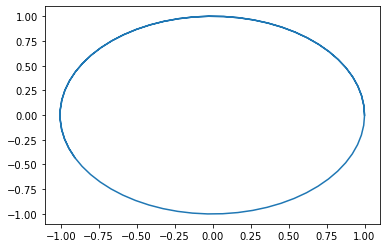

In [30]:
plt.plot(x, y)

We can also plot the circular velocity as a function of radius.

Text(0, 0.5, 'circular velocity')

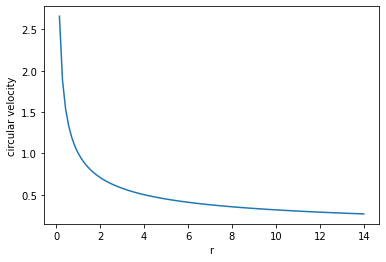

In [22]:
# can use np.arange to build an array of x,y values from 0.1 to 10
x = np.arange(0.1,10,0.1)
y = np.arange(0.1,10,0.1)
r = np.sqrt(x**2 + y**2)

vcirc = circular_velocity(Mass, x, y, G=1)

r = np.sqrt(x**2 + y**2)

plt.plot(r, vcirc)
plt.xlabel('r')
plt.ylabel('circular velocity')

And the time period of an orbit as a funcion of radius.

Text(0, 0.5, 'Time Period')

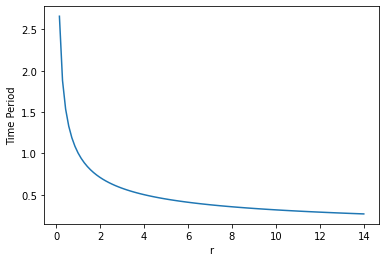

In [23]:
Tp = time_period(Mass, x, y, G=1)

plt.plot(r, vcirc)
plt.xlabel('r')
plt.ylabel('Time Period')

## Exercises 

What happens when you experiment with your initial phase-space coordinates?

What happens when the change the size of dt in your integration? In the context of the equations of motion, why do you this happens? 

# Orbit Integration in Gala

We just walked through the innerworkings of the Leapfrog algorithm, but the gala orbital dynamics package can do all of this as well! We can find the Keplerian Potential in gala's potential library called gala.ptoential, which we imported as gp. We define an initial phasespace position, timestep, and total length, just like  we did above. With all that, gala can perform the same operation with only a few lines of code.

And as we see below, we arrive at the same results.

In [59]:
# Gala plot for comparison
pot = gp.KeplerPotential(m=1) # defining potential with mass of central body equal to 1
w0 = gd.PhaseSpacePosition(pos=[1, 0, 0], vel=[0, 1, 0]) # define initial phase space coordinates
star_orbit = pot.integrate_orbit(w0, dt=0.1, t1=0, t2=10) # run integration after defining timestep and start/end of time interval

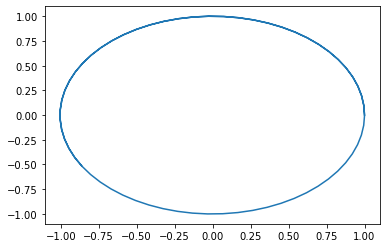

In [60]:
plt.plot(star_orbit.x, star_orbit.y)

So this was a brief tutorial showing how to integrate orbits in a simple Keplerian potential. But what about more complicated potentials? Like the Keplarian case, the Hernquist Potential is a spherical potential but rather than orbiting in a potential set by a single point mass, the mass distribution in the Hernquist Potential is a centrally concentrated mass distibution that falls off with radius. $$\Phi = \frac{-G M}{r+c}$$
The new parameter c can be thought of as as a measure of how concentrated the mass distribution is that defines the potential and M is the total mass of the object it representds. 

The actual details of this potential are not so important right now, other than that it can be used as a rough representation of mass in something like a galaxy. Given what we know now about orbit integration and gala, you should have the tools now to write your own leapfrog code for the Hernquist potential and how to run orbit integrator schemes using gala. 

In [32]:
Mass = 1e12 # mass of the halo in solar masses 
c = 15 # mass concentration in kiloparsecs

Pot = gp.HernquistPotential(Mass, c, units=galactic) # units defines which unit system we are using. 
# We will learn more about this along the way but for the sake fo this demonstraton, we will use "Galactic"

w0 = gd.PhaseSpacePosition(pos=[10., 0., 0]*u.kpc,
                           vel=[0., 200, 0]*u.km/u.s) # initial phase space coordinates (with units attached)

Can you integrate this orbit in gala? Make plots of the orbit in (x,y).

Calculate the total energy $E(t)$ of your orbit at each timestep at time $t$ and make a plot of the fractional drift in energy $(E(t)-E(0))/E(0)$ as a function $t$.

Some things to try over the next week for the Hernquist potential:

Analytically find algebraic expressions for \  
--- the radial acceleration at radius r:     $ a_r = - dΦ/dr $ \
--- velocity of a circular orbit at that radius using:    $a_r = - v_{\rm circ}^2/r$ \
--- the azimuthal orbital time period for a circular orbit:    $T = 2\pi r/ v_{\rm circ}$

Make plots $v_{\rm circ}$ and $T$ vs $r$ using python. Think about what good units are to use and label your axes.

Use these results to think about what initial conditions (x0,y0), (vx0,vy0)  you should choose to launch a circular orbit at any radius in your Hernquist potential. 

Numerically integrate your orbit using gala \
--- Plot your orbit in x-y: is it circular? \
--- Check your results against estimates for time periods above \
--- Check your orbit conserves energy \
--- See what happens when you lower/increase the timestep
